In [1]:
### Imports ###
import pandas as pd
from Bio import SeqIO
import pysam
import matplotlib.pyplot as plt




In [2]:
### Arguments ###
checkm_report =  "../outputs/zymo/metaMDBG/metabat2_bins_reads_alignement/checkm_report.txt"
bins_directory = "../outputs/zymo/metaMDBG/metabat2_bins_reads_alignement/bins"
reads_on_contigs_alignment = "../outputs/zymo/metaMDBG/reads_on_contigs.bam"
reads_path = "/groups/genscale/nimauric/long_reads/zymoD6331.fastq"


In [3]:
### Data processing ###

#I) : get the quality of each bin
def GSCS_quality(contamination, completeness, contigs) : 
    if ((contamination <=1) and (completeness >=99) and (contigs <=1)) : 
        return "near complete"   
    if ((contamination <=5) and (completeness >=90)) :
        return "high quality"     
    if ((contamination <=10) and (completeness >=50)) :
        return "medium quality"   
    return "low quality"


bin_to_quality = pd.read_csv(checkm_report, sep='\s+', skiprows=6, 
    names = ["Bin ID", "Marker", "lineage", "genomes", "markers", "sets", "0", "1", "2", "3", "4", "5+", 
             "Completeness", "Contamination", "Strain hetero", "Contigs", "Size", "N50", "N50/Size"])

bin_to_quality["Quality"] = bin_to_quality.apply(lambda x: GSCS_quality(x['Contamination'], x['Completeness'], x['Contigs']), axis=1)
bin_to_quality = {bin_id: quality for bin_id, quality in zip(bin_to_quality["Bin ID"], bin_to_quality["Quality"])}

In [4]:
#II) : get the bin of each contig

max_bin = str(len(bin_to_quality.keys()))
bin_number = 0
contig_to_bin={}
for bin_name in bin_to_quality.keys() : 
    bin_number +=1
    print("\rprocessing bin " + str(bin_number) + "/" + max_bin + "...", end='', flush=True)
    
    with open(bins_directory + "/"+ bin_name + ".fa", "r") as fasta_file :
        for record in SeqIO.parse(fasta_file, "fasta"):
            contig_to_bin[record.name] = bin_name
        


processing bin 1/23...

processing bin 23/23...

In [5]:

#III) : get the quality of the bin containing the contigs that each read is aligned to, with the length of the alignments

reads_to_quality = {}

# Open the BAM file
with pysam.AlignmentFile(reads_on_contigs_alignment, "rb") as bamfile:
    # Iterate over each read in the BAM file
    for alignment in bamfile.fetch():
        read_name = alignment.query_name
        contig_name = alignment.reference_name
        try :
            bin_name = contig_to_bin[contig_name]
            quality = bin_to_quality[bin_name]
        except KeyError : 
            quality = "unbinned"

        start_pos = alignment.query_alignment_start
        end_pos = alignment.query_alignment_end

        alignment = (quality, start_pos, end_pos, alignment.query_alignment_length)
    
        if read_name in reads_to_quality : 
            reads_to_quality[read_name].append(alignment)
        else : 
            reads_to_quality[read_name] = [alignment]




In [6]:
#IV) : get the length of each read
reads_to_length = {}
with open(reads_path, "r") as reads_file :
    i=0
    for line in reads_file:
        line = line.strip()
        if i == 0:
            name= line[1:].split(" ")[0]
        elif i == 1:
            length = len(line)
        elif i == 3:
            i= -1
            reads_to_length[name] = length
        i+=1


In [7]:
qualities = ["unmapped", "unbinned", "low quality", "medium quality", "high quality","near complete"]


alignment_lengths = {"unmapped" : 0, "unbinned" : 0, "low quality" : 0, "medium quality" : 0, "high quality" : 0,"near complete" : 0}
aligned_reads_count = {"unmapped" : 0, "unbinned" : 0, "low quality" : 0, "medium quality" : 0, "high quality" : 0,"near complete" : 0}

for read_name, alignments in reads_to_quality.items():
    alignments = sorted(alignments, key=lambda x: x[1])

    # Merge overlapping alignments of the same quality
    merged_alignments = [("unmapped", 0, reads_to_length[read_name], reads_to_length[read_name])]
    for quality in qualities[1:] : 
        current_alignment = (quality, 0, 0, 0)
        for alignment in alignments :
            if alignment[0] != quality :
                continue
            max_quality = quality
            if alignment[1] <= current_alignment[2]:
                maximum = max(alignment[2], current_alignment[2])
                current_alignment = (quality, current_alignment[1], maximum, maximum-current_alignment[1])
            else:
                if current_alignment[1] != 0 or current_alignment[2] != 0:
                    merged_alignments.append(current_alignment)
                current_alignment = alignment
        if current_alignment[1] != 0 or current_alignment[2] != 0:
            merged_alignments.append(current_alignment)
    aligned_reads_count[max_quality] += 1
    
    # Remove overlaps between alignments of different qualities, and store the alignemnt lengths
    test_trimmed=0
    for alignment in merged_alignments:
        quality_index = qualities.index(alignment[0])
        start_pos = alignment[1]
        end_pos = alignment[2]
        
        for potential_overlap in merged_alignments : 
            if qualities.index(potential_overlap[0]) > quality_index : 
                overlap_start_pos = potential_overlap[1]
                overlap_end_pos = potential_overlap[2]
                # Trim the start of the alignment
                if(start_pos <= overlap_end_pos and start_pos >= overlap_start_pos) :
                    start_pos = overlap_end_pos 
                # Trim the end of the alignment
                if(end_pos >= overlap_start_pos and end_pos <= overlap_end_pos) : 
                    end_pos = overlap_start_pos
                # Split the alignment in two
                if(start_pos < overlap_start_pos and end_pos > overlap_end_pos) : 
                    merged_alignments.append((alignment[0],start_pos, overlap_start_pos, overlap_start_pos-start_pos))
                    merged_alignments.append((alignment[0],overlap_end_pos, end_pos, end_pos-overlap_end_pos))
                    start_pos = 0
                    end_pos = 0
                    break
        # If not empty, add the new alignement
        if start_pos < end_pos : 
           test_trimmed += end_pos-start_pos
           alignment_lengths[alignment[0]] += end_pos-start_pos

# Add the information from unaligned reads
for r in reads_to_length.keys() :
    if r not in reads_to_quality.keys() :
        aligned_reads_count["unmapped"] += 1
        alignment_lengths["unmapped"] += reads_to_length[r]


In [8]:
### Plotting ###
# Print numbers
total_aligned_reads = 0
total_aligned_length = 0

reads_count = len(reads_to_length)
reads_length = sum(reads_to_length.values())
aligned_reads_count_ratio = {}
alignements_length_ratio = {}
for q in qualities : 
    total_aligned_reads += aligned_reads_count[q]
    total_aligned_length += alignment_lengths[q]

    aligned_reads_count_ratio[q] = aligned_reads_count[q] / reads_count
    alignements_length_ratio[q] = alignment_lengths[q]/ reads_length
    print("quality :", q)
    print("aligned reads over total reads count ratio : {:.2f}% ({}/{})".format(aligned_reads_count_ratio[q] * 100,aligned_reads_count[q], reads_count ))
    print("alignement length over total reads length ratio : {:.2f}% ({}/{})".format(alignements_length_ratio[q] * 100, alignment_lengths[q], reads_length))
    print()

print(total_aligned_reads/reads_count)
print(total_aligned_length/reads_length)

quality : unmapped
aligned reads over total reads count ratio : 0.05% (906/1978852)
alignement length over total reads length ratio : 0.35% (63048975/17993566711)

quality : unbinned
aligned reads over total reads count ratio : 0.57% (11328/1978852)
alignement length over total reads length ratio : 0.68% (121519897/17993566711)

quality : low quality
aligned reads over total reads count ratio : 4.17% (82578/1978852)
alignement length over total reads length ratio : 4.79% (861867503/17993566711)

quality : medium quality
aligned reads over total reads count ratio : 0.00% (0/1978852)
alignement length over total reads length ratio : 0.00% (0/17993566711)

quality : high quality
aligned reads over total reads count ratio : 8.63% (170808/1978852)
alignement length over total reads length ratio : 9.42% (1695065295/17993566711)

quality : near complete
aligned reads over total reads count ratio : 86.58% (1713232/1978852)
alignement length over total reads length ratio : 84.76% (15252065041/1

/tmp/ipykernel_10413/911385806.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


Done !


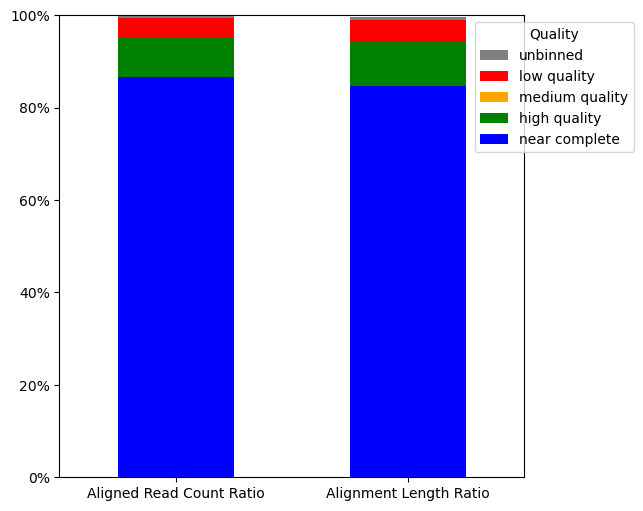

In [25]:

colors = ['blue', 'green', 'orange', 'red', 'grey']

df = pd.concat([pd.DataFrame(aligned_reads_count_ratio, index=["aligned_reads_count_ratio"]), pd.DataFrame(alignements_length_ratio, index=["alignement_length_ratio"]) ])
df = df[["near complete", "high quality", "medium quality", "low quality", "unbinned"]]
plt.figure(figsize=(6,6))
axes = plt.axes()

df.plot(kind='bar', stacked=True, ax=axes, color=colors)
axes.set_ylim([0, 1])
plt.xticks(rotation=0, ha='center')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), title="Quality", reverse=True)

plt.xticks(range(2), ["Aligned Read Count Ratio", "Alignment Length Ratio"])

print("Done !")

